# Extraction studies

WIP for making plots related to extractions.  Portions of this notebook could be converted to standalone scripts
to make them easier to re-run in the future.

# NOTE: this notebook is deprecated, please run this instead:

```
python plotex_ccd_patch.py
python plotex_wavelengths.py
python plotex_full_vs_patch_bias.py
python plotex_covcorr_pull.py
```

In [1]:
#- non-DESI imports
import os, sys, glob, time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import fitsio

from astropy.visualization import ZScaleInterval

plt.ion();

In [2]:
#- DESI imports
import desispec.io
from desispec.io import findfile, read_image, read_frame
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from specter.psf import load_psf
from specter.extract import ex2d

## Divide and Conquer

### Visualize a single extraction patch

In [3]:
specprod = 'fuji'
os.environ['SPECPROD'] = specprod
reduxdir = os.path.expandvars(f'$DESI_ROOT/spectro/redux/{specprod}/preproc/')
night = 20210101
expid = 70350
camera = 'r1'

In [4]:
img = read_image(findfile('preproc', night, expid, camera))
psf = load_psf(findfile('psf', night, expid, camera))

INFO:image.py:104:read_image: iotime 0.702 sec to read preproc-r1-00070350.fits at 2022-06-02T11:04:59.929553


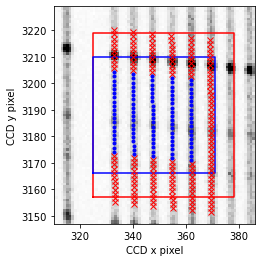

In [5]:
dw = 0.8
ww = 7300 + np.arange(20)*dw
specrange = (25,30)

pixpad_frac=0.8
wavepad_frac=0.2
ny, nx = spotsize = psf.pix(specrange[0], ww[0]).shape
extra_ypix = int(round(pixpad_frac * ny))

x1, x2, y1, y2 = psf.xyrange(specrange, ww)
y1a = y1 - extra_ypix
y2a = y2 + extra_ypix

x2a = psf.xyrange(specrange[1], ww)[1]

wmin = psf.wavelength(specrange[0], y1a-int(ny*wavepad_frac))
wmax = psf.wavelength(specrange[0], y2a+int(ny*wavepad_frac))

waveall = 7300-50*dw + np.arange(200)*dw
ii = (wmin <= waveall) & (waveall <= wmax)
waveall = waveall[ii]
jj = (waveall < ww[0]) | (ww[-1] < waveall)
waveextra = waveall[jj]

x0, x3 = x1-15, x2+15
y0, y3 = y1a-10, y2a+10
patch0 = img.pix[y1:y2, x1:x2] * (img.ivar[y1:y2, x1:x2] > 0) * (img.mask[y1:y2, x1:x2]==0)
patch1 = img.pix[y0:y3, x0:x3] * (img.ivar[y0:y3, x0:x3] > 0) * (img.mask[y0:y3, x0:x3]==0)
vmin, vmax = ZScaleInterval().get_limits(patch1)

plt.figure(figsize=(4,4))
plt.imshow(patch1, extent=(x0-0.5,x3-0.5,y0-0.5,y3-0.5), vmin=vmin, vmax=vmax, cmap='Greys')
# plt.imshow(patch0, extent=(x1-0.5,x2-0.5,y1-0.5,y2-0.5), vmin=vmin, vmax=vmax, cmap='Blues')

plt.plot([x1,x2a,x2a,x1,x1], [y1a,y1a,y2a,y2a,y1a], 'r-')
plt.plot([x1,x2,x2,x1,x1], [y1,y1,y2,y2,y1], 'b-')

for i in range(*specrange):
    x, y = psf.xy(i, waveextra)
    plt.plot(x, y, 'rx')
    x, y = psf.xy(i, ww)
    plt.plot(x, y, 'b.')

x, y = psf.xy(specrange[1], waveall)
plt.plot(x, y, 'rx')

plt.xlim(x0,x3); plt.ylim(y0,y3)
plt.xlabel('CCD x pixel'); plt.ylabel('CCD y pixel')
plt.savefig('extraction_ccd_patch.pdf')

### Extraction Bias

Compare results from full extraction with those from divide-and-conquer

In [6]:
dw = 0.8
nwave = 200
wave = 7300 + np.arange(nwave)*dw
nspec = 5

flux, ivar, rdat = ex2d(img.pix, img.ivar*(img.mask==0), psf, 25, nspec, wave, wavesize=nwave)
# plt.plot(wave, flux[0], 'k-')

subwave = list()
subflux = list()
subivar = list()
npatch = 4
for ww in np.array_split(wave, npatch):
    f1, iv1, rdat1 = ex2d(img.pix, img.ivar*(img.mask==0), psf, 25, nspec, ww)
    subwave.append(ww)
    subflux.append(f1)
    subivar.append(iv1)  
    # plt.plot(ww, f1[0], '-')

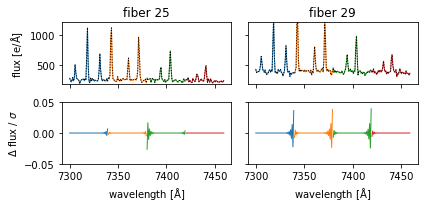

In [7]:
plt.figure(figsize=(6,3))

#- Flux fiber 25
ax = plt.subplot(221)
for w1, f1, iv1 in zip(subwave, subflux, subivar):
    plt.plot(w1, f1[0], lw=1)

plt.plot(wave, flux[0], 'k:', lw=1)
plt.ylim(200, 1200)
plt.ylabel(r'flux [e/$\mathrm{\AA}$]')
plt.title('fiber 25')
ax.axes.xaxis.set_ticklabels([])

#- Flux fiber 29
ax = plt.subplot(222)
for w1, f1, iv1 in zip(subwave, subflux, subivar):
    plt.plot(w1, f1[4], lw=1)
plt.ylim(200, 1200)

plt.plot(wave, flux[4], 'k:', lw=1)
plt.title('fiber 29')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

#- Flux differences
ax = plt.subplot(223)
for w1, f1, iv1 in zip(subwave, subflux, subivar):
    ii = np.isin(wave, w1)
    plt.plot(w1, (flux[0][ii] - f1[0]) * np.sqrt(iv1[0]), lw=1)

plt.ylim(-0.05, 0.05)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
plt.ylabel('$\Delta$ flux / $\sigma$')

ax = plt.subplot(224)
for w1, f1, iv1 in zip(subwave, subflux, subivar):
    ii = np.isin(wave, w1)
    plt.plot(w1, (flux[4][ii] - f1[4]) * np.sqrt(iv1[4]), lw=1)

plt.ylim(-0.05, 0.05)
plt.xlabel(r'wavelength [$\mathrm{\AA}$]')
ax.axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig('extraction_full_vs_patch_bias.pdf')

## Choice of wavelength grid

Compare the choice of extraction resolution to the pixel scale and instrument resolution

In [8]:
camera_psf = dict()
wavelengths = dict()
for camera in ['b1', 'r1', 'z1']:
    camera_psf[camera] = load_psf(findfile('psf', night, expid, camera))
    wavelengths[camera] = fitsio.read(findfile('frame', night, expid, camera), 'WAVELENGTH')

b1 3600.0 5800.0
r1 5760.0 7620.0
z1 7520.0 9824.0


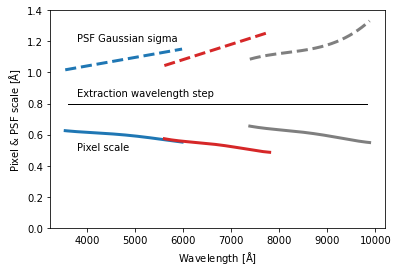

In [9]:
i=100
colors = dict(b1='C0', r1='C3', z1='C7')
plt.figure(figsize=(6,4))
for camera, psf in camera_psf.items():
    wmin = wavelengths[camera][0]
    wmax = wavelengths[camera][-1]
    print(f'{camera} {wmin:.1f} {wmax:.1f}')
    ww = psf.wavelength(i, np.arange(0, psf.npix_y))
    plt.plot(ww, np.gradient(ww), color=colors[camera], lw=3)
    plt.plot(ww, psf.ysigma(i, ww), '--', color=colors[camera], lw=3)

plt.text(3800, 1.2, 'PSF Gaussian sigma')

plt.plot([3600, 9824], [0.8, 0.8], 'k-', lw=1)
plt.text(3800, 0.85, 'Extraction wavelength step')

plt.ylabel(r'Pixel & PSF scale [$\mathrm{\AA}$]')
plt.xlabel(r'Wavelength [$\mathrm{\AA}$]')
plt.ylim(0.0, 1.4)
plt.text(3800, 0.5, 'Pixel scale')
plt.savefig('extraction_wavelengths.pdf')

## Covariance from a simulated spectrum

Re-extract N>>1 times with different noise realizations

In [10]:
psf = load_psf(findfile('psf', night, expid, 'r1'))

In [11]:
dw = 0.8
ww = 7300 + np.arange(50)*dw

In [12]:
nspec = 1
nwave = len(ww)
# inphot = 10*np.ones((nspec, nwave))
inphot = np.tile(np.linspace(1,1000,nwave), nspec).reshape(nspec, nwave)
inphot[0,15] += 500
inphot[0,25] += 1000
inphot[0,35] += 10000

xyrange = xmin, xmax, ymin, ymax = psf.xyrange((0,nspec), ww)
simpix = psf.project(ww, inphot, xyrange=xyrange)

In [13]:
np.random.seed(0)
readnoise = 3.0
imgivar = 1/(simpix + readnoise**2)

### Extract with multiple noise realizations

In [14]:
np.random.seed(0)
multiflux = list()
multiivar = list()
multirdat = list()
ntest = 10000
t0 = time.time()
for i in range(ntest):
    simimg = np.random.poisson(simpix) + np.random.normal(scale=readnoise, size=simpix.shape)
    flux, ivar, rdat = ex2d(simimg, imgivar, psf, specmin=0, nspec=1, wavelengths=ww, xyrange=xyrange)
    multiflux.append(flux.ravel())
    multiivar.append(ivar.ravel())
    multirdat.append(rdat)
    
multiflux = np.array(multiflux)
multiivar = np.array(multiivar)

dt = time.time() - t0
print(f'{dt/60:.1f} minutes to process {ntest} extractions')

1.4 minutes to process 10000 extractions


In [15]:
cov = np.cov(multiflux, rowvar=False)
corr = np.corrcoef(multiflux, rowvar=False)

#- detail: ivar only depends upon input pixel variance, not the noisy signal,
#- so every row of multiivar is actually the same; take the mean anyway in case
#- we update how to do the sims...
meanvar = np.mean(1/multiivar, axis=0)

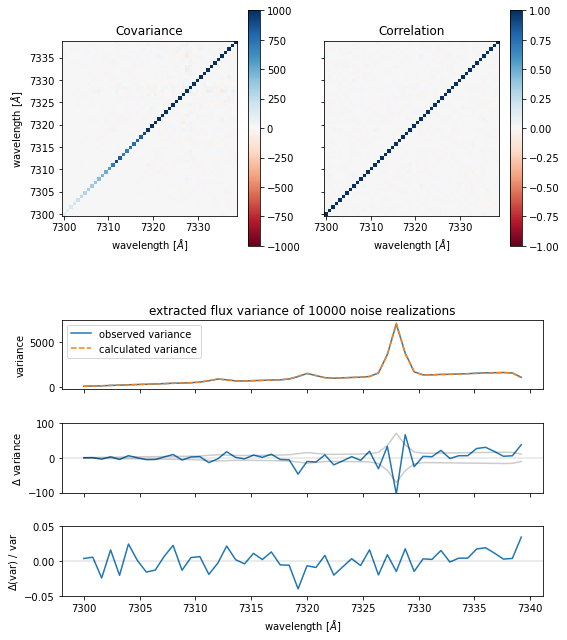

In [16]:
# plt.figure(figsize=(8,3.5))
plt.figure(figsize=(8,9))
plt.subplot(221)
vmax=1000
extent=(ww[0]-dw/2,ww[-1]-dw/2,ww[0]-dw/2,ww[-1]-dw/2)
plt.imshow(cov, vmin=-vmax, vmax=vmax, cmap='RdBu', extent=extent)
plt.colorbar()
plt.title('Covariance')
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel(r'wavelength [$\AA$]')

ax = plt.subplot(222)
plt.imshow(corr, vmin=-1, vmax=1, cmap='RdBu', extent=extent)
plt.title('Correlation')
plt.xlabel(r'wavelength [$\AA$]')
# plt.ylabel(r'wavelength [$\AA$]')
ax.axes.yaxis.set_ticklabels([])
plt.colorbar()

ax = plt.subplot(614)
plt.plot(ww, np.diag(cov), label='observed variance')
plt.plot(ww, meanvar, '--', label='calculated variance')
plt.ylabel('variance')
# plt.xlabel(r'wavelength [$\AA$]')
plt.title(f'extracted flux variance of {ntest} noise realizations')
ax.axes.xaxis.set_ticklabels([])
plt.legend()

ax = plt.subplot(615)
deltacov = (np.diag(cov) - meanvar)
plt.plot(ww, deltacov)
errvar = np.sqrt(2*meanvar**2 / (2*ntest))  # error on the variance, maybe
plt.plot(ww, errvar, color='k', alpha=0.2)
plt.plot(ww, -errvar, color='k', alpha=0.2)
plt.axhline(0, color='k', alpha=0.1)
plt.ylim(-100, 100)
plt.ylabel(r'$\Delta$ variance')
ax.axes.xaxis.set_ticklabels([])

ax = plt.subplot(616)
deltacov = (np.diag(cov) - np.mean(1/multiivar, axis=0)) / np.diag(cov)
plt.plot(ww, deltacov)
plt.axhline(0, color='k', alpha=0.1)
plt.ylim(-0.05, 0.05)
plt.ylabel(r'$\Delta$(var) / var')
plt.xlabel(r'wavelength [$\AA$]')

plt.tight_layout()

plt.savefig('extraction_covcorr.pdf')

## Pull of extractions on an exactly aligned wavelength grid

In [17]:
R = Resolution(rdat[0])
model = R.dot(inphot[0])/dw

In [18]:
pull = (multiflux - model)*np.sqrt(multiivar)
np.mean(pull), np.std(pull), 1.4828*np.median(np.abs(pull - np.median(pull)))

(-0.002081317648022917, 1.0005977209849775, 1.0011868014000815)

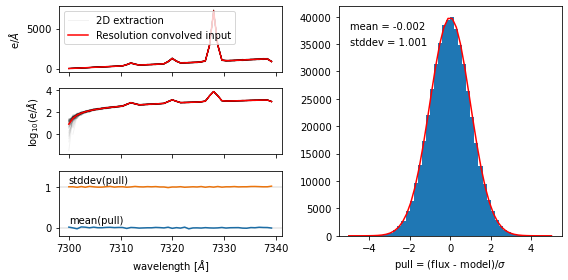

In [19]:
# plt.figure(figsize=(12,4))
plt.figure(figsize=(8,4))
ax = plt.subplot(321)
for i in range(100):
    label = '2D extraction' if i==0 else None
    plt.plot(ww, multiflux[i], 'k-', lw=1, alpha=0.05, label=label)

plt.plot(ww, model, 'r-', label='Resolution convolved input')
# plt.plot(ww, rowflux, '-', color='C0', label='row-by-row')
plt.ylabel(r'e/$\AA$')
plt.legend(loc='upper left')
ax.axes.xaxis.set_ticklabels([])

#- log(flux)
ax = plt.subplot(323)
for i in range(100):
    label = '2D extraction' if i==0 else None
    y = multiflux[i].copy()
    y[y<0] = np.NaN
    plt.plot(ww, np.log10(y), 'k-', lw=1, alpha=0.05, label=label)

plt.plot(ww, np.log10(model), 'r-', label='Resolution convolved input')
plt.ylabel(r'$\log_{10}$(e/$\AA$)')
ax.axes.xaxis.set_ticklabels([])

#- pull mean and std vs. wavelength
ax = plt.subplot(325)
plt.plot(ww, np.mean(pull, axis=0))
plt.plot(ww, np.std(pull, axis=0))
plt.axhline(0.0, color='k', alpha=0.1)
plt.axhline(1.0, color='k', alpha=0.1)
plt.text(ww[0], 0.1, 'mean(pull)')
plt.text(ww[0], 1.1, 'stddev(pull)')
plt.xlabel(r'wavelength [$\AA$]')
plt.ylim(-0.2, 1.4)

#- histogram pull
ax = plt.subplot(122)
plt.hist(pull.ravel(), 50, (-5, 5))
plt.xlabel(r'pull = (flux - model)/$\sigma$')
xx = np.linspace(-5, 5)
yy = np.exp(-xx**2/2) * pull.size/np.sqrt(2*np.pi) / 5
plt.plot(xx, yy, 'r-')
chimean = np.mean(pull)
chistd = np.std(pull)
plt.text(0.05, 0.90, f'mean = {chimean:.3f}', transform=ax.transAxes)
plt.text(0.05, 0.83, f'stddev = {chistd:.3f}', transform=ax.transAxes);
plt.tight_layout()

plt.savefig('extraction_pull.pdf')

## Spectroperfectionism extractions != row-by-row

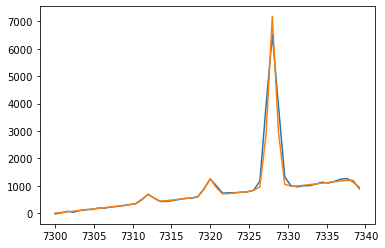

In [20]:
ywave = psf.wavelength(0, y=np.arange(ymin, ymax))
yflux = np.sum(simimg, axis=1) / np.gradient(ywave)
yyflux = resample_flux(ww, ywave, yflux)

R = Resolution(rdat[0])
model = R.dot(inphot[0])/dw

# plt.plot(ywave, yflux)
plt.plot(ww, yyflux)
plt.plot(ww, model)

## Simulated image

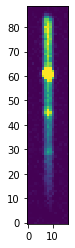

In [21]:
plt.imshow(simimg, vmin=0, vmax=200)

## Ringing from too small extraction resolution

**This is not longer an issue with the latest padding**

Study extraction ringing and biases vs. extraction resolution and PSF model accuracy.

In [22]:
specprod = 'fuji'
os.environ['SPECPROD'] = specprod
reduxdir = os.path.expandvars('$DESI_ROOT/spectro/redux/fuji/preproc/')
night = 20210101
expid = 70270
camera = 'r0'

In [23]:
img = read_image(findfile('preproc', night, expid, camera))

INFO:image.py:104:read_image: iotime 0.572 sec to read preproc-r0-00070270.fits at 2022-06-02T11:06:35.265240


In [24]:
psf = load_psf(findfile('psf', night, expid, camera))

In [25]:
psf.wmin_all, psf.wmax_all

(5608.070918476519, 7735.615849341416)

In [26]:
def test_extract(dwave=0.8):
    nwave = int(50/dwave)
    wave = 7300 + np.arange(nwave)*dwave
    nspec = 5
    flux, ivar, rdat = ex2d(img.pix, img.ivar*(img.mask==0), psf, 0, nspec, wave)
    
    c = np.polyfit(wave, flux[0], 2)
    model = np.polyval(c, wave)
    chi2 = np.sum( (flux[0]-model)**2 * ivar[0] )
    rchi2 = chi2/nwave
    
    return wave, flux, ivar, rdat, model, rchi2

In [27]:
wave, flux, ivar, rdat, model, rchi2 = test_extract()
print(rchi2)

1.0393521657663984


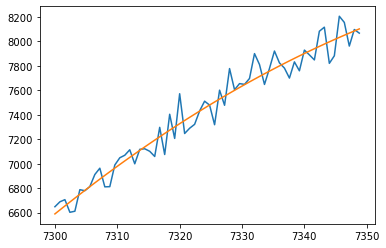

In [28]:
plt.plot(wave, flux[0])
plt.plot(wave, model)

0.4 1.0447424579609539
0.6 1.130542505642046
0.8 1.0393521657663984
1.0 1.0671228187355777
1.2 1.0153368297086667
1.4 1.016043069197475
1.8 0.7610190901524395
2.0 0.9896644952756557
2.2 1.0439882919235886
2.4 0.571707522285428


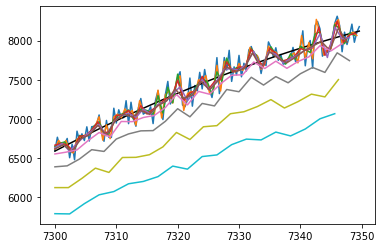

In [29]:
for dwave in (0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.8, 2.0, 2.2, 2.4):
    wave, flux, ivar, rdat, model, rchi2 = test_extract(dwave)
    print(dwave, rchi2)
    plt.plot(wave, flux[0])
    if dwave == 0.4:
        plt.plot(wave, model, 'k-')